In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from klap.datasets.ground_truth import spherical_eigenvals
from klap.utils.config import SAVE_DIR

SAVE_DIR = SAVE_DIR / 'test'

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)

In [3]:
def get_average(method, all_runs):
    key = ['n', 'd', 'p', 'kernel', 'kernel_param']
    if method == 'graph_laplacian':
        runs = all_runs[all_runs['graph_laplacian'] > 0]
        key.append('graph_laplacian')
    if method == 'galerkin':
        runs = all_runs[all_runs['graph_laplacian'] == 0]
    elif method == 'graph_laplacian_special':
        runs = all_runs[all_runs['graph_laplacian'] == -1]

    df = runs.groupby(key)['error'].mean().reset_index()
    df['error_std'] = runs.groupby(key)['error'].std().reset_index()['error']
    df['time'] = runs.groupby(key)['time'].mean().reset_index()['time']
    df['time_std'] = runs.groupby(key)['time'].std().reset_index()['time']
    return df


def get_best(df, key):
    return df.loc[df.dropna().groupby(key).error.idxmin()]

In [4]:
# get all runs
names = ['exponential', 'gaussian', 'polynomial']

res = []
for name in names:
    save_dir = SAVE_DIR / name
    for task_id in range(1, 501):
        filename = save_dir / f'task_{task_id}.jsonl'
        with open(filename, 'rt') as f:
            res += [json.loads(line) for line in f]
all_runs = pd.DataFrame(res)
all_runs['eigenvalues'] = all_runs['eigenvalues'].apply(np.array)

In [5]:
k = 25

key = ['n', 'd', 'p', 'kernel', 'kernel_param', 'graph_laplacian']
all_runs['eigmean'] = all_runs['eigenvalues'].apply(np.sum)
all_runs['eigmean_runs'] = all_runs.groupby(key)['eigmean'].transform(np.mean)

pred = all_runs['eigenvalues'] / all_runs['eigmean_runs']
pred **= -1
pred = np.stack(pred.values)

all_runs['my_error'] = 0
for d in range(3, 20, 2):
    eigenvals = spherical_eigenvals(d, k)
    eigenvals *= np.sum(eigenvals[1:]**(-1))
    error = pred - eigenvals
    error[:, 0] = 0
    error = np.abs(error).sum(axis=1) 
    error /= np.sum(eigenvals)

    error[all_runs.d.values != d] = 0
    all_runs['my_error'] += error

In [6]:
all_runs['error'][all_runs['graph_laplacian'] != 0] = all_runs['my_error'][all_runs['graph_laplacian'] != 0]

/tmp/ipykernel_1994640/2079228902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs['error'][all_runs['graph_laplacian'] != 0] = all_runs['my_error'][all_runs['graph_laplacian'] != 0]


In [7]:
# names = ['galerkin', 'graph_laplacian', 'graph_laplacian_special']
names = ['galerkin', 'graph_laplacian']

# average error over runs
galerkin = get_average('galerkin', all_runs)
graph_lap = get_average('graph_laplacian', all_runs)
graph_lap_special = get_average('graph_laplacian_special', all_runs)

## Influence of d and n

In [8]:
# best hyperparameters
key = ['n', 'd']

galerkin_best = get_best(galerkin, key)
graph_lap_best = get_best(graph_lap, key)
graph_lap_special_best = get_best(graph_lap_special, key)

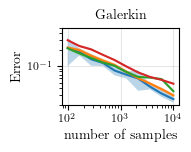

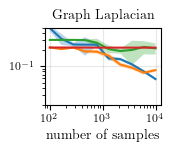

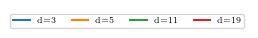

In [9]:
for name in names:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.error.values)
        ax.fill_between(tmp.n.values, tmp.error - tmp.error_std.values, tmp.error + tmp.error_std.values, alpha=.3)
        leg.append(a)
    if name == 'galerkin':
        ax.set_ylabel('Error', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.loglog()
    ax.set_xlabel('number of samples', fontsize=10)
    ax.set_ylim([2e-2, 5e-1])
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_varying_d.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(1, .1))
ax.legend(leg, ['d=3', 'd=5', 'd=11', 'd=19'], fontsize=6, ncol=4)
ax.set_axis_off()
# fig.savefig(f'legend_varying_d.pdf', bbox_inches='tight')

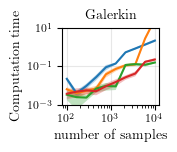

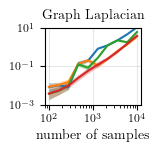

In [10]:
for name in names:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.25, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.time.values)
        ax.fill_between(tmp.n.values, tmp.time - tmp.time_std.values, tmp.time + tmp.time_std.values, alpha=.3)
        leg.append(a)
    if name == 'galerkin':
        ax.set_ylabel('Computation time', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.loglog()
    ax.set_ylim([1e-3, 1e1])
    ax.set_xlabel('number of samples', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_best_time_varying_d.pdf', bbox_inches='tight')

#### Chechking hyperparameters

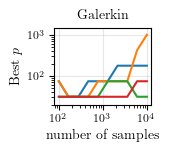

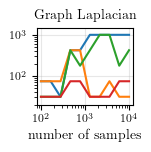

In [11]:
for name in names:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.25, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.p.values)
        leg.append(a)
    if name == 'galerkin':
        ax.set_ylabel('Best $p$', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.loglog()
    ax.set_ylim([2e1, 1.5e3])
    ax.set_xlabel('number of samples', fontsize=10)
    ax.grid(alpha=.3)
    fig.savefig(f'{name}_best_p_varying_d.pdf', bbox_inches='tight')

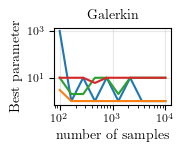

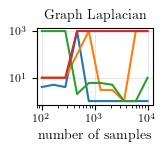

In [12]:
for name in names:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.kernel_param.values)
        leg.append(a)
    if name == 'galerkin':
        ax.set_ylabel('Best parameter', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_title('Graph Laplacian', fontsize=10)
    ax.loglog()
    ax.set_xlabel('number of samples', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_best_param_varying_d.pdf', bbox_inches='tight')

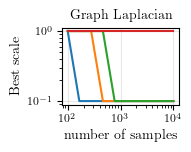

In [13]:
for name in ['graph_laplacian']:
    if name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.graph_laplacian.values)
        leg.append(a)
    ax.loglog()
    ax.set_xlabel('number of samples', fontsize=10)
    ax.set_title('Graph Laplacian', fontsize=10)
    ax.set_ylabel('Best scale', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_best_scale_varying_d.pdf', bbox_inches='tight')

## Scaling with respect to $d$

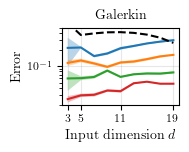

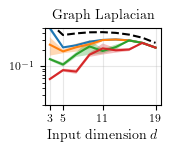

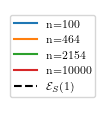

In [14]:
ds = [3, 5, 7, 9, 11, 13, 15, 17, 19]
error = np.empty(len(ds))
ns = [100, 464, 2154, 10000]

for i_d, d in enumerate(ds):
    eigenvals = spherical_eigenvals(d, k)
    eigenvals *= np.sum(eigenvals[1:]**(-1))
    pred = np.ones(k)
    pred /= np.sum(pred)
    pred **= -1
    pred -= eigenvals
    error[i_d] = np.abs(pred).sum() 
    error[i_d] /= np.sum(eigenvals)

for name in names:
    if name == 'galerkin':
        df = galerkin_best
    elif name == 'graph_laplacian':
        df = graph_lap_best
    elif name == 'graph_laplacian_special':
        df = graph_lap_special_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for n in ns:
        tmp = df[df.n == n]
        a, = ax.plot(tmp.d.values, tmp.error.values)
        ax.fill_between(tmp.d.values, tmp.error - tmp.error_std.values, tmp.error + tmp.error_std.values, alpha=.3)
        leg.append(a)
    if name == 'galerkin':
        ax.set_ylabel('Error', fontsize=10)
        ax.set_title('Galerkin', fontsize=10)
    else:
        ax.set_title('Graph Laplacian', fontsize=10)
    a, = ax.plot(ds, error, '--', color='black')
    leg.append(a)
    ax.set_yscale('log')
    ax.set_xlabel(r'Input dimension $d$', fontsize=10)
    ax.set_xticks([3, 5, 11, 19])
    ax.set_xticklabels(['3', '5', '11', '19'])
    ax.set_ylim([2e-2, 5e-1])
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_varying_n.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1, 1, figsize=(1, 1.5))
ax.legend(leg, ['n=100', 'n=464', 'n=2154', 'n=10000', r'${\cal E}_S(1)$'], fontsize=8, ncol=1)
ax.set_axis_off()
# fig.savefig(f'legend_varying_n.pdf', bbox_inches='tight')

## Influence of the kernel
The polynomial kernel is well-specified, gaussian is not. Does it matter?

In [15]:
# best hyperparameters
key = ['n', 'd']

exponential = galerkin[galerkin.kernel == 'exponential']
gaussian = galerkin[galerkin.kernel == 'gaussian']
polynomial = galerkin[galerkin.kernel == 'polynomial']

exponential_best = get_best(exponential, key)
gaussian_best = get_best(gaussian, key)
polynomial_best = get_best(polynomial, key)

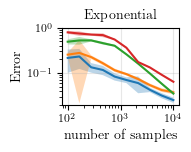

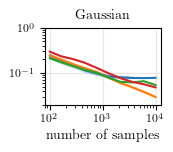

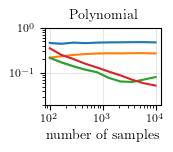

In [16]:
names = ['exponential', 'Gaussian', 'polynomial']

for name in names:
    if name == 'exponential':
        df = exponential_best
    elif name == 'Gaussian':
        df = gaussian_best
    elif name == 'polynomial':
        df = polynomial_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.error.values)
        ax.fill_between(tmp.n.values, tmp.error - tmp.error_std.values, tmp.error + tmp.error_std.values, alpha=.3)
        leg.append(a)
    if name == 'exponential':
        ax.set_ylabel('Error', fontsize=10)
        ax.set_title('Exponential', fontsize=10)
    elif name == 'Gaussian':
        ax.set_title('Gaussian', fontsize=10)
    elif name == 'polynomial':
        ax.set_title('Polynomial', fontsize=10)
    ax.loglog()
    ax.set_xlabel('number of samples', fontsize=10)
    ax.set_ylim([2e-2, 1e0])
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_varying_d.pdf', bbox_inches='tight')

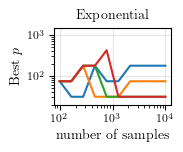

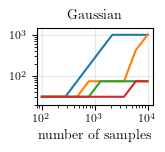

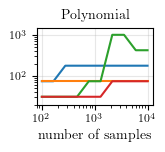

In [17]:
for name in names:
    if name == 'exponential':
        df = exponential_best
    elif name == 'Gaussian':
        df = gaussian_best
    elif name == 'polynomial':
        df = polynomial_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.p.values)
        leg.append(a)
    if name == 'exponential':
        ax.set_ylabel('Best $p$', fontsize=10)
        ax.set_title('Exponential', fontsize=10)
    elif name == 'Gaussian':
        ax.set_title('Gaussian', fontsize=10)
    elif name == 'polynomial':
        ax.set_title('Polynomial', fontsize=10)
    ax.loglog()
    ax.set_ylim([2e1, 1.5e3])
    ax.set_xlabel('number of samples', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_best_p_varying_d.pdf', bbox_inches='tight')

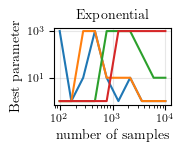

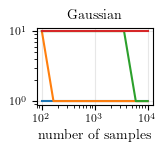

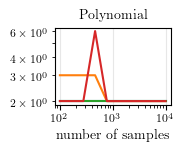

In [18]:
for name in names:
    if name == 'exponential':
        df = exponential_best
    elif name == 'Gaussian':
        df = gaussian_best
    elif name == 'polynomial':
        df = polynomial_best

    fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))
    leg = []
    for d in [3, 5, 11, 19]:
        tmp = df[df.d == d]
        a, = ax.plot(tmp.n.values, tmp.kernel_param.values)
        leg.append(a)
    if name == 'exponential':
        ax.set_ylabel('Best parameter', fontsize=10)
        ax.set_title('Exponential', fontsize=10)
    elif name == 'Gaussian':
        ax.set_title('Gaussian', fontsize=10)
    elif name == 'polynomial':
        ax.set_title('Polynomial', fontsize=10)
    ax.loglog()
    ax.set_xlabel('number of samples', fontsize=10)
    ax.grid(alpha=.3)
    # fig.savefig(f'{name}_best_param_varying_d.pdf', bbox_inches='tight')